In [7]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import deepxde as dde
from neuralop.data.datasets import DarcyDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
dde.config.set_default_float("float32")

# 파일 경로 설정 (사용자 환경에 맞게 수정해주세요)
BASE_DIR = "C:/Users/admin/Desktop/김도형/코드"
DATA_DIR = os.path.join(BASE_DIR, "Dataset")
MODEL_DIR = os.path.join(BASE_DIR, "model")
os.makedirs(MODEL_DIR, exist_ok=True)
MODEL_SAVE_PATH = os.path.join(MODEL_DIR, "deepxde_deeponet_cnnbranch_ver2cnn_like.ckpt")

# 데이터 파일 경로
train_resolution = 32
test_resolutions = [16, 32, 64]

dataset = DarcyDataset(
    root_dir=DATA_DIR,
    n_train=2000, n_tests=[20, 20, 20],
    batch_size=50, test_batch_sizes=[20, 20, 20],
    train_resolution=train_resolution, test_resolutions=test_resolutions,
    download=True
)

train_loader = DataLoader(dataset.train_db, batch_size=50, shuffle=False,
                          num_workers=2, pin_memory=True)

test_loaders = {res: DataLoader(db, batch_size=20, shuffle=False,
                                num_workers=2, pin_memory=True)
                for res, db in dataset.test_dbs.items()}

Using device: cuda:0
Set the default float type to float32
Loading test db for resolution 16 with 20 samples 
Loading test db for resolution 32 with 20 samples 
Loading test db for resolution 64 with 20 samples 


In [2]:
# trunk 좌표 (ver2_CNN과 동일)
def make_trunk_coords(res):
    xs = np.linspace(0.0, 1.0, res, dtype=np.float32)
    ys = np.linspace(0.0, 1.0, res, dtype=np.float32)
    X, Y = np.meshgrid(xs, ys, indexing="ij")
    trunk = np.stack([X.reshape(-1), Y.reshape(-1)], axis=1).astype(np.float32)  # (res^2, 2)
    return trunk

X_train_trunk = make_trunk_coords(train_resolution)  # (1024, 2)

# =========================
# 2) DataLoader -> DeepXDE TripleCartesianProd용 (N, 1024) 배열로 변환
#    - ver2_CNN: branch는 (N,1,32,32)로 사용했지만
#      DeepXDE branch 입력은 기본적으로 (N,1024) 형태가 깔끔함.
#      대신 CNN branch 안에서 다시 (B,1,32,32)로 reshape함.
# =========================
def loader_to_numpy_xy(dl, res):
    X_list, Y_list = [], []
    for batch in dl:
        x = batch["x"]  # (B,1,res,res)
        y = batch["y"]  # (B,1,res,res)

        B = x.shape[0]
        x_flat = x.view(B, -1).cpu().numpy().astype(np.float32)  # (B, res^2)
        y_flat = y.view(B, -1).cpu().numpy().astype(np.float32)  # (B, res^2)

        X_list.append(x_flat)
        Y_list.append(y_flat)

    X = np.concatenate(X_list, axis=0)
    Y = np.concatenate(Y_list, axis=0)
    return X, Y

X_train_branch, y_train = loader_to_numpy_xy(train_loader, train_resolution)

# 테스트는 “32 해상도” 기준으로 ver2_CNN과 공정 비교
X_test_branch_32, y_test_32 = loader_to_numpy_xy(test_loaders[32], 32)
X_test_trunk_32 = make_trunk_coords(32)

print("Train branch:", X_train_branch.shape)  # (2000, 1024)
print("Train trunk :", X_train_trunk.shape)   # (1024, 2)
print("Train y     :", y_train.shape)         # (2000, 1024)

Train branch: (2000, 1024)
Train trunk : (1024, 2)
Train y     : (2000, 1024)


In [3]:
# =========================
# 3) DeepXDE 데이터
# =========================
data = dde.data.TripleCartesianProd(
    X_train=(X_train_branch, X_train_trunk),
    y_train=y_train,
    X_test=(X_test_branch_32, X_test_trunk_32),
    y_test=y_test_32
)

In [4]:
# =========================
# 4) ver2_CNN.ipynb와 동일한 CNN Branch를 DeepXDE branch로 주입
#    ver2_CNN Branch:
#      Conv2d(1->64, stride2) ReLU
#      Conv2d(64->128, stride2) ReLU
#      Conv2d(128->256, stride2) ReLU
#      Flatten
#      Linear(256*4*4 -> 512) ReLU
#      Linear(512 -> 256)
# =========================
class CNNBranch_Ver2CNN(nn.Module):
    """
    입력:  (B, 1024)  (flatten)
    내부:  (B,1,32,32)로 reshape 후 CNN
    출력:  (B, p=256)
    """
    def __init__(self, res=32, p=256, hidden_dim2=512):
        super().__init__()
        self.res = res
        self.p = p

        self.net = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1), nn.ReLU(),
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, hidden_dim2), nn.ReLU(),
            nn.Linear(hidden_dim2, p),
        )

        # ver2_CNN과 동일하게 Xavier init
        self.apply(self._init_weights)

    @staticmethod
    def _init_weights(m):
        if isinstance(m, (nn.Linear, nn.Conv2d)):
            nn.init.xavier_normal_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def forward(self, x):
        # x: (B, 1024)
        b = x.shape[0]
        x = x.view(b, 1, self.res, self.res)
        return self.net(x)  # (B, p)

# trunk는 ver2_CNN과 동일: 2 -> 256 -> 512 -> 256
p = 256
branch_net = CNNBranch_Ver2CNN(res=32, p=p, hidden_dim2=512)

net = dde.nn.DeepONetCartesianProd(
    # DeepXDE 관례: [input_dim, callable/custom_module]
    layer_sizes_branch=[32 * 32, branch_net],
    layer_sizes_trunk=[2, 256, 512, p],
    activation="relu",
    kernel_initializer="Glorot normal",
)

model = dde.Model(data, net)

Compiling model...
'compile' took 1.167832 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [2.39e-01]    [3.09e-01]    [1.01e+00]    
1000      [7.28e-03]    [9.90e-03]    [1.79e-01]    
Epoch 1000: train loss improved from inf to 7.28e-03, saving model to C:/Users/admin/Desktop/김도형/코드\model\deepxde_deeponet_cnnbranch_ver2cnn_like.ckpt-1000.pt ...

2000      [2.18e-03]    [4.89e-03]    [1.21e-01]    
Epoch 2000: train loss improved from 7.28e-03 to 2.18e-03, saving model to C:/Users/admin/Desktop/김도형/코드\model\deepxde_deeponet_cnnbranch_ver2cnn_like.ckpt-2000.pt ...

3000      [1.79e-03]    [4.64e-03]    [1.18e-01]    
Epoch 3000: train loss improved from 2.18e-03 to 1.79e-03, saving model to C:/Users/admin/Desktop/김도형/코드\model\deepxde_deeponet_cnnbranch_ver2cnn_like.ckpt-3000.pt ...

4000      [1.51e-03]    [4.95e-03]    [1.19e-01]    
Epoch 4000: train loss improved from 1.79e-03 to 1.51e-03, saving model to C:/Users/admin/Desktop/김도형/코드\model\deep

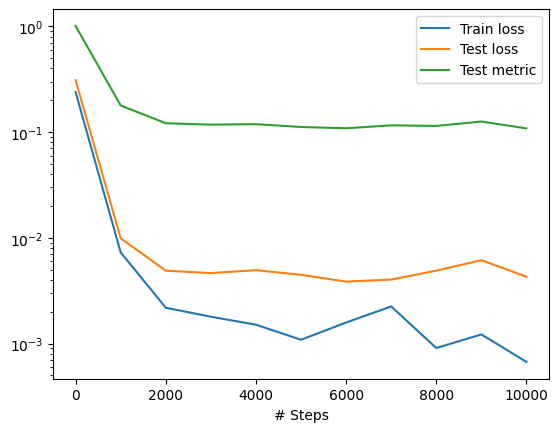

In [ ]:
# =========================
# 5) 학습: ver2_CNN과 맞춤
#    - ver2_CNN: Adam lr=1e-3, MSE, 10000 epoch(사실상 iterations)
# =========================
model.compile("adam", lr=1e-3, metrics=["mean l2 relative error"])

checker = dde.callbacks.ModelCheckpoint(
    MODEL_SAVE_PATH,
    save_better_only=True,
    period=1000,
    verbose=1
)

# DeepXDE iterations는 "optimizer step 수"에 가까움
# ver2_CNN의 epoch 개념과 1:1 매핑은 아니지만, 비교 목적으로 10000부터 시작
losshistory, train_state = model.train(
    iterations=10000,
    callbacks=[checker],
    # (권장) 배치 학습: ver2_CNN처럼 batch_size=50 느낌으로 맞추기
    batch_size=50
)

dde.saveplot(losshistory, train_state, issave=False, isplot=True)

In [12]:
# ==============================================================================
# DeepXDE DeepONet (CNN-branch 버전) 해상도별(16/64) 검증 + 시각화
# - 지금 구조(DarcyDataset/test_loaders 사용, branch는 32로 보간 후 flatten, trunk는 target res)
# - 모델 출력: (N, res^2)
# ==============================================================================
def make_trunk_coords(resolution: int) -> np.ndarray:
    x_lin = np.linspace(0.0, 1.0, resolution, dtype=np.float32)
    y_lin = np.linspace(0.0, 1.0, resolution, dtype=np.float32)
    Xg, Yg = np.meshgrid(x_lin, y_lin, indexing="ij")
    X_trunk = np.stack([Xg.reshape(-1), Yg.reshape(-1)], axis=1).astype(np.float32)  # (res^2, 2)
    return X_trunk

def _collect_xy_from_loader(test_loader):
    """test_loader에서 전체 x,y를 모아서 torch tensor로 반환. (N,1,res,res)"""
    xs, ys = [], []
    for batch in test_loader:
        x = batch["x"]
        y = batch["y"]

        # (N,Res,Res) -> (N,1,Res,Res) 보정
        if x.dim() == 3:
            x = x.unsqueeze(1)
        if y.dim() == 3:
            y = y.unsqueeze(1)

        # dtype 보정 (bool/int 방지)
        xs.append(x.float().cpu())
        ys.append(y.float().cpu())

    x_all = torch.cat(xs, dim=0)
    y_all = torch.cat(ys, dim=0)
    return x_all, y_all

def test_resolution_deepxde(
    resolution: int,
    test_loader,
    model,
    train_resolution: int = 32,
    vis_idx: int = 0,
):
    """
    resolution: 평가하려는 해상도 (16/32/64)
    test_loader: 해당 resolution의 DataLoader (DarcyDataset의 test_loaders[res])
    model: dde.Model
    train_resolution: branch 입력이 학습된 해상도(=32)
    """
    print(f"\n========== Testing Resolution: {resolution}x{resolution} (DeepXDE DeepONet) ==========")

    # 1) Raw data 모으기
    x_raw, y_raw = _collect_xy_from_loader(test_loader)  # (N,1,res,res)
    N = x_raw.shape[0]

    # 2) Branch input: 학습해상도(32)로 보간 -> flatten (N, 1024)
    if resolution != train_resolution:
        x_in = F.interpolate(
            x_raw, size=(train_resolution, train_resolution),
            mode="bilinear", align_corners=False
        )
    else:
        x_in = x_raw

    X_branch = x_in.reshape(N, -1).numpy().astype(np.float32)

    # 3) Trunk input: target resolution 좌표 (res^2, 2)
    X_trunk = make_trunk_coords(resolution)

    # 4) 예측: (N, res^2)
    y_pred_flat = model.predict((X_branch, X_trunk)).astype(np.float32)

    # 5) 정답 flatten: (N, res^2)
    y_true_flat = y_raw.reshape(N, -1).numpy().astype(np.float32)

    # 6) Relative L2 error (sample-wise)
    diff_norm = np.linalg.norm(y_pred_flat - y_true_flat, axis=1)
    true_norm = np.linalg.norm(y_true_flat, axis=1)
    l2_errors = diff_norm / (true_norm + 1e-6)

    avg_error = float(np.mean(l2_errors))
    print(f"총 테스트 샘플 수: {len(l2_errors)}")
    print(f"평균 Relative L2 Error: {avg_error*100:.2f}%")

    # 7) 시각화(첫 샘플)
    idx = int(np.clip(vis_idx, 0, N - 1))

    vis_input = x_raw[idx, 0].numpy()                         # (res,res)
    vis_true  = y_raw[idx, 0].numpy()                         # (res,res)
    vis_pred  = y_pred_flat[idx].reshape(resolution, resolution)
    vis_error = np.abs(vis_true - vis_pred)

    fig, axes = plt.subplots(1, 4, figsize=(20, 4))
    titles = [
        f"Input (raw {resolution}x{resolution})",
        "Ground Truth",
        "DeepONet (DeepXDE)",
        "Absolute Error",
    ]
    images = [vis_input, vis_true, vis_pred, vis_error]

    for ax, img, title in zip(axes, images, titles):
        im = ax.imshow(img, cmap="viridis")
        ax.set_title(title)
        plt.colorbar(im, ax=ax)
        ax.axis("off")

    plt.tight_layout()
    plt.savefig(f"C:/Users/admin/Desktop/김도형/코드/figure_20260213_labmeeting/result_don_xde_cnn_sample_{resolution}.png", dpi=300, bbox_inches="tight")
    plt.show()

    return avg_error, l2_errors


========== Testing Resolution: 16x16 (DeepXDE DeepONet) ==========
총 테스트 샘플 수: 20
평균 Relative L2 Error: 19.94%


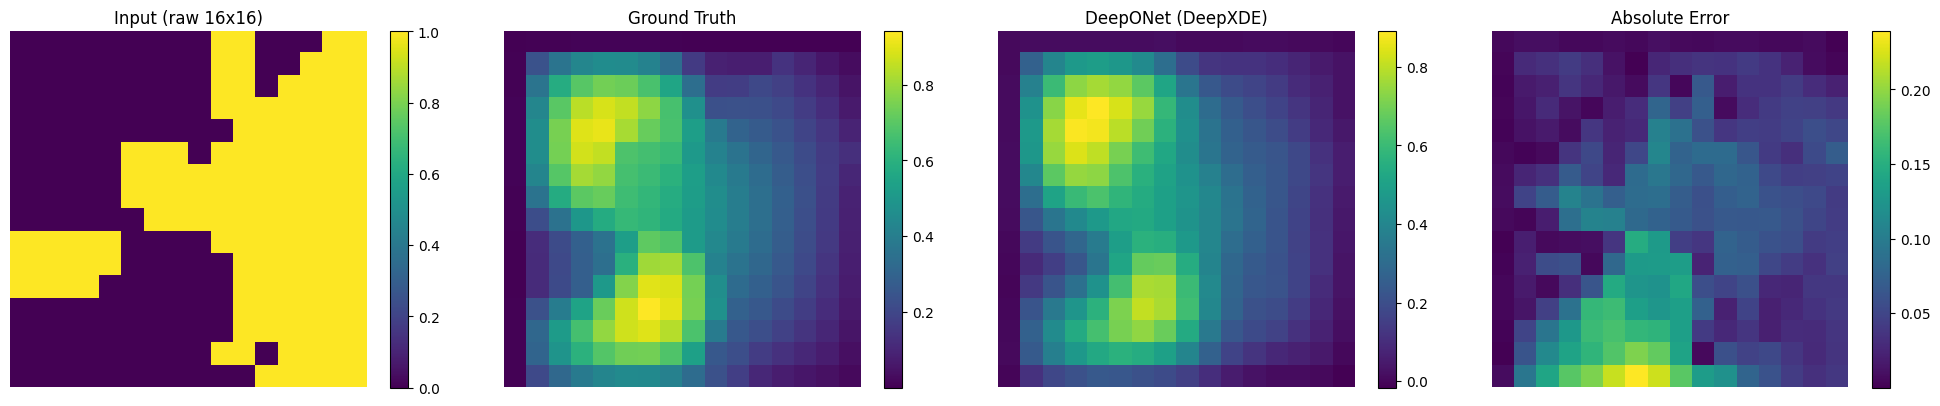


========== Testing Resolution: 32x32 (DeepXDE DeepONet) ==========
총 테스트 샘플 수: 20
평균 Relative L2 Error: 10.84%


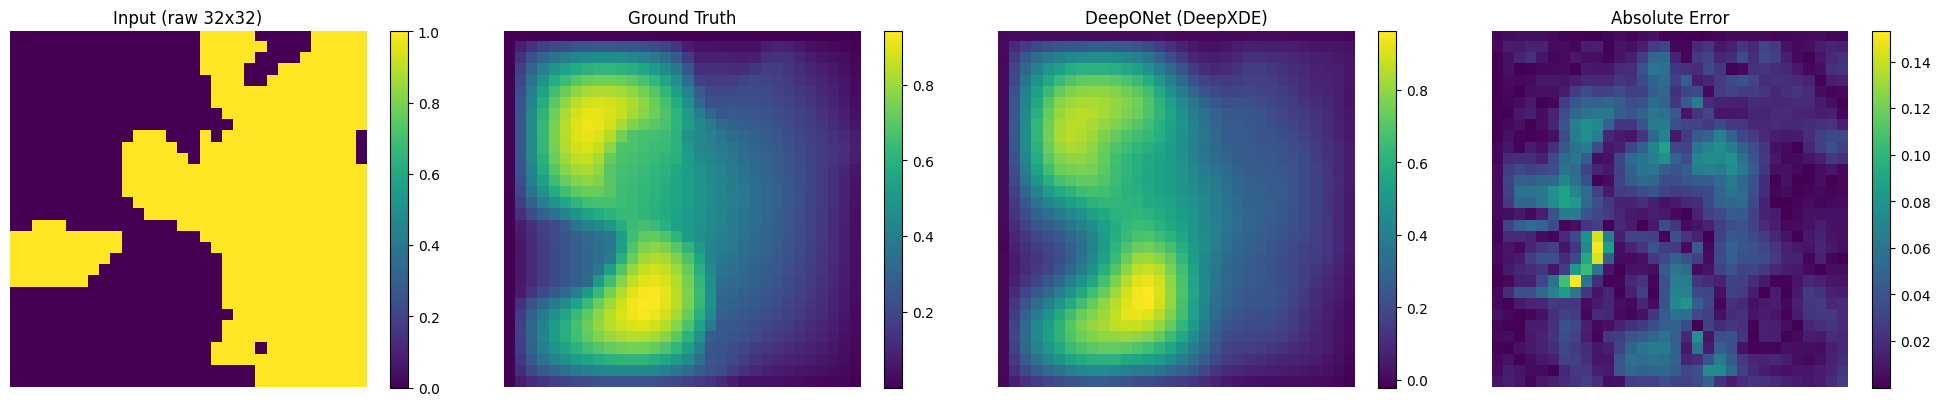


========== Testing Resolution: 64x64 (DeepXDE DeepONet) ==========
총 테스트 샘플 수: 20
평균 Relative L2 Error: 12.41%


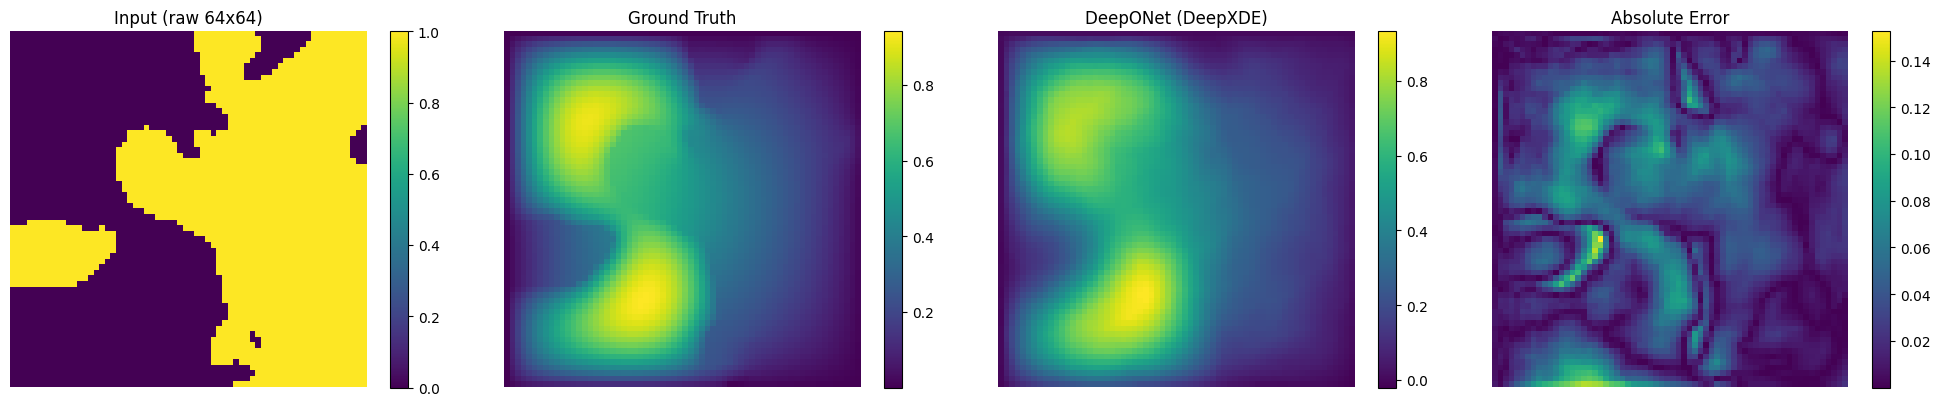

(0.12406222522258759,
 array([0.08796895, 0.06385149, 0.10692826, 0.09535887, 0.12017941,
        0.19745195, 0.14624876, 0.09809775, 0.10178153, 0.14253339,
        0.07560161, 0.13941409, 0.07548379, 0.24482973, 0.22971047,
        0.08867465, 0.10515868, 0.08211856, 0.09709024, 0.1827625 ],
       dtype=float32))

In [13]:
# (1) 체크포인트 로드
model.restore("C:/Users/admin/Desktop/김도형/코드/model/deepxde_deeponet_cnnbranch_ver2cnn_like.ckpt-10000.pt")

# (2) DarcyDataset에서 만든 test_loaders 사용
test_resolution_deepxde(16, test_loaders[16], model)
test_resolution_deepxde(32, test_loaders[32], model)
test_resolution_deepxde(64, test_loaders[64], model)